In [1]:
import SimpleITK as sitk
import mdai
import pandas as pd
import numpy as np
import cv2
import pydicom
import os
import multiprocessing as mp
import functools
from functools import partial
import mdai
import math
import time
import itertools
from pydicom.fileset import FileSet
from os import path as pathOs
from pathlib import Path
import toolz
from toolz.curried import pipe, map, filter, get
from toolz import curry
from os.path import basename, dirname, exists, isdir, join, split
import nnunetv2

import elastixRegister as elastixRegister
from elastixRegister import reg_a_to_b

from toolz.itertoolz import groupby
from toolz import curry
# import multiprocess
# p = multiprocess.Pool(os.cpu_count())
import multiprocessing as mp
import json
import os
from subprocess import Popen
import subprocess
import pymia.evaluation.metric as metric
import pymia.evaluation.evaluator as eval_
import pymia.evaluation.writer as writer
from itertools import product


In [2]:
# inferred_example_path='/home/sliceruser/workspaces/konwersjaJsonData/to_eval_test_cases/inferred/inferred_test_cases/9002600.nii.gz'
# gold_standard_labels_path='/home/sliceruser/workspaces/konwersjaJsonData/to_eval_test_cases/sources/Dataset287_Prostate/labelsTr/9002600.nii.gz'

# inferred_example_img= sitk.ReadImage(inferred_example_path)
# gold_standard_labels_img= sitk.ReadImage(gold_standard_labels_path)


In [21]:
""" 
we identify all single lesion files associated with our inferred label 
and we calculate how many of them has at least 80% coverage in the inferred area
we will also calculate the percent of whole area that is not covered by any lesion
"""
def get_bool_arr_from_path(pathh):
    """
    given path reads it and return associated array
    then it casts it to boolean data type
    """
    imageA=sitk.ReadImage(pathh)
    return sitk.GetArrayFromImage(imageA).astype(bool)


import pathlib
gold_detailed = list(pathlib.Path("/home/sliceruser/workspaces/konwersjaJsonData/to_eval_test_cases/sources_detailed/Dataset287_Prostate/labelsTr").iterdir())
inferred=list(pathlib.Path("/home/sliceruser/workspaces/konwersjaJsonData/to_eval_test_cases/inferred/inferred_test_cases").iterdir())

gold_detailed= list(filter(lambda ppath: 'nii.gz' in ppath.name ,gold_detailed))
inferred= list(filter(lambda ppath: 'nii.gz' in ppath.name ,inferred))

# curr_inferred=inferred[4]




# all_associated_with_numberr=list(map(lambda el: el.name,all_associated_with_numberr))
# single_lesions=list(map(lambda el: el.name,single_lesions))
# lesions_sum=lesions_sum.name

# single_lesions=list(map(lambda el: '_' in el.name ,all_associated_with_numberr))
# lesions_sum = list(filter(lambda el: '_' not in el.name ,all_associated_with_numberr))[0]

def is_in_x_percent(path_lesion,path_inferred_sum,greater_then):
    """ 
    checking weather at least 80 percent of given lesion is in the inferred lesion sum
    """
    path_lesion=str(path_lesion)
    path_inferred_sum=str(path_inferred_sum)
    lesion=get_bool_arr_from_path(path_lesion)
    inferred_sum=get_bool_arr_from_path(path_inferred_sum)
    andd=np.logical_and(lesion,inferred_sum)
    andd= np.sum(andd.flatten())
    lesion= np.sum(lesion.flatten())
    res= andd/lesion
    # print(res)
    return res>greater_then

# example_path=list(dirr.iterdir())

# example_path[0].name
def iter_inferred(curr_inferred,greater_then):
    curr_inferred_name= curr_inferred.name
    nuberrr=curr_inferred.stem.replace('.nii','')
    all_associated_with_numberr=list(filter(lambda el: nuberrr in el.name,gold_detailed))
    single_lesions=list(filter(lambda el: '_' in el.name ,all_associated_with_numberr))
    lesions_sum = list(filter(lambda el: '_' not in el.name ,all_associated_with_numberr))[0]
    return np.array(list(map(lambda les : is_in_x_percent(les,curr_inferred,greater_then),single_lesions)))

def get_coverage_for_percent(greater_then):
    resss=np.concatenate(list(map(lambda curr : iter_inferred(curr,greater_then),inferred)))
    resss=np.sum(resss.flatten())
    return (greater_then, resss/305)


full_coverage= list(map(get_coverage_for_percent,np.arange(0,1,0.001) ))

KeyboardInterrupt: 

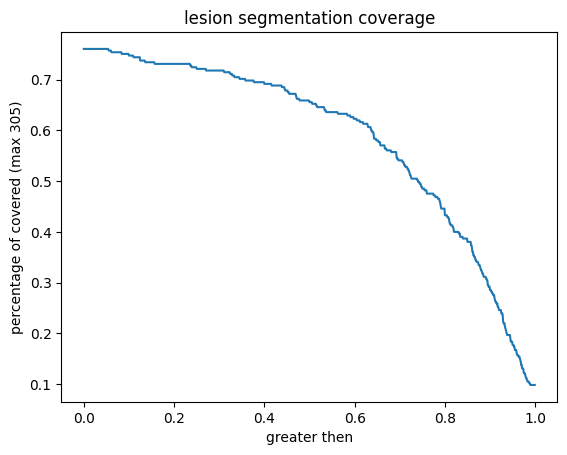

In [25]:
import matplotlib.pyplot as plt

x_axis = np.array(list(map(lambda tupl: tupl[0],full_coverage)))
y_axis = np.array(list(map(lambda tupl: tupl[1],full_coverage)))/305

plt.plot(x_axis, y_axis)
plt.title('lesion segmentation coverage')
plt.xlabel('greater then')
plt.ylabel('percentage of covered (max 305)')
plt.show()

In [13]:
# #dicee 
# def get_my_dice(path_gold_sum,path_inferred_sum):
#     """ 
#     checking weather at least 80 percent of given lesion is in the inferred lesion sum
#     """
#     path_gold_sum=str(path_gold_sum)
#     path_inferred_sum=str(path_inferred_sum)
#     gold_sum=get_bool_arr_from_path(path_gold_sum)
#     inferred_sum=get_bool_arr_from_path(path_inferred_sum)
#     andd=np.logical_and(gold_sum,inferred_sum)
#     andd= np.sum(andd.flatten())*2
#     res= andd/(np.sum(gold_sum.flatten() )+  np.sum(inferred_sum.flatten() )  )
#     # print(res)
#     return res
# def iter_inferred_for_dice(curr_inferred):
#     curr_inferred_name= curr_inferred.name
#     nuberrr=curr_inferred.stem.replace('.nii','')
#     all_associated_with_numberr=list(filter(lambda el: nuberrr in el.name,gold_detailed))
#     lesions_sum = list(filter(lambda el: '_' not in el.name ,all_associated_with_numberr))[0]
#     return get_my_dice(lesions_sum,curr_inferred)

# dicess=list(map(iter_inferred_for_dice,inferred))
# np.mean(dicess)


metrics = [metric.DiceCoefficient(), metric.HausdorffDistance(percentile=95, metric='HDRFDST95'), metric.VolumeSimilarity()]
labels = {1: 'segmentation' }

def iter_inferred_for_metrics(curr_inferred,evaluator):
    curr_inferred_name= curr_inferred.name
    nuberrr=curr_inferred.stem.replace('.nii','')
    all_associated_with_numberr=list(filter(lambda el: nuberrr in el.name,gold_detailed))
    gold_path = list(filter(lambda el: '_' not in el.name ,all_associated_with_numberr))[0]
    # print(f"curr_inferred {curr_inferred} gold_path {gold_path}")
    # return get_my_dice(lesions_sum,curr_inferred)
    evaluator.evaluate(sitk.ReadImage(gold_path), sitk.ReadImage(curr_inferred), curr_inferred_name)
    
evaluator = eval_.SegmentationEvaluator(metrics, labels)
metricss=list(map(lambda pathh:iter_inferred_for_metrics(pathh,evaluator),inferred))

functions = {'MEAN': np.mean, 'STD': np.std}
writer.CSVStatisticsWriter("/workspaces/konwersjaJsonData/explore/test_metrics/adc_hbv_prostate_res_summary.csv", functions=functions).write(evaluator.results)





writer.CSVWriter("/workspaces/konwersjaJsonData/explore/test_metrics/adc_hbv_prostate_res.csv").write(evaluator.results)


Unable to compute Hausdorff distance due to empty reference mask, returning inf
invalid value encountered in subtract


# Full prostate anatomical

In [12]:
gold_standard_full_prostate_path="/home/sliceruser/workspaces/konwersjaJsonData/nnunetMainFolder/nnUNet_raw/Dataset280_Prostate/labelsTr"
inferred_full_prostate_path="/home/sliceruser/workspaces/konwersjaJsonData/nnunetMainFolder/my_prost_infered"


gold_standard_full_prostate = list(pathlib.Path(gold_standard_full_prostate_path).iterdir())
inferred_full_prostate=list(pathlib.Path(inferred_full_prostate_path).iterdir())

gold_standard_full_prostate= list(filter(lambda ppath: 'nii.gz' in ppath.name ,gold_standard_full_prostate))
inferred_full_prostate= list(filter(lambda ppath: 'nii.gz' in ppath.name ,inferred_full_prostate))

evaluator = eval_.SegmentationEvaluator(metrics, labels)

def iter_inferred_for_metrics(curr_inferred,evaluator):
    curr_inferred_name= curr_inferred.name
    nuberrr=curr_inferred.stem.replace('.nii','')
    all_associated_with_numberr=list(filter(lambda el: nuberrr in el.name,gold_standard_full_prostate))
    gold_path = list(filter(lambda el: '_' not in el.name ,all_associated_with_numberr))[0]
    # print(f"curr_inferred {curr_inferred} gold_path {gold_path}")
    # return get_my_dice(lesions_sum,curr_inferred)
    evaluator.evaluate(sitk.ReadImage(gold_path), sitk.ReadImage(curr_inferred), curr_inferred_name)

metricss=list(map(lambda pathh:iter_inferred_for_metrics(pathh,evaluator),inferred_full_prostate))

functions = {'MEAN': np.mean, 'STD': np.std}
writer.CSVStatisticsWriter("/workspaces/konwersjaJsonData/explore/test_metrics/full_prostate_res_summary.csv", functions=functions).write(evaluator.results)





writer.CSVWriter("/workspaces/konwersjaJsonData/explore/test_metrics/full_prostate_res.csv").write(evaluator.results)
